In [1]:
### IMPORTING REQUIRED PACKAGES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# machine learning modules
import sklearn
print(sklearn.__version__)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.utils import shuffle

0.18.2


In [2]:
#### LOADING DATA ####

train_data = pd.read_csv("train.csv", na_values='-1')
test_data = pd.read_csv("test.csv", na_values='-1')
print(train_data.shape)
print(test_data.shape)

(595212, 59)
(892816, 58)


In [3]:
desired_apriori=0.90

# Get the indices per target value
idx_0 = train_data[train_data.target == 0].index
idx_1 = train_data[train_data.target == 1].index

# Get original number of records per target value
nb_0 = len(train_data.loc[idx_0])
nb_1 = len(train_data.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
train_data = train_data.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.00420290983796
Number of records with target=0 after undersampling: 2410


In [4]:
## Filling the missing data NAN with median of the column
train_data_nato_median = pd.DataFrame()
for column in train_data.columns:
    train_data_nato_median[column] = train_data[column].fillna(train_data[column].median())

train_data = train_data_nato_median.copy()

## Filling the missing data NAN with mean of the column
test_data_nato_median = pd.DataFrame()
for column in test_data.columns:
    test_data_nato_median[column] = test_data[column].fillna(test_data[column].median())
    
test_data = test_data_nato_median.copy()
test_data_id = test_data.pop('id')

In [5]:
## Identifying Categorical data
column_names = train_data.columns
categorical_column = column_names[column_names.str[10] == 'c']

## Changing categorical columns to category data type
def int_to_categorical(data):
    """ 
    changing columns to catgorical data type
    """
    for column in categorical_column:
        data[column] =  data[column].astype('category')

In [6]:
## Creating list of train and test data and converting columns of interest to categorical type
datas = [train_data,test_data]

for data in datas:
    int_to_categorical(data)

print(test_data.dtypes)

ps_ind_01            int64
ps_ind_02_cat     category
ps_ind_03            int64
ps_ind_04_cat     category
ps_ind_05_cat     category
ps_ind_06_bin        int64
ps_ind_07_bin        int64
ps_ind_08_bin        int64
ps_ind_09_bin        int64
ps_ind_10_bin        int64
ps_ind_11_bin        int64
ps_ind_12_bin        int64
ps_ind_13_bin        int64
ps_ind_14            int64
ps_ind_15            int64
ps_ind_16_bin        int64
ps_ind_17_bin        int64
ps_ind_18_bin        int64
ps_reg_01          float64
ps_reg_02          float64
ps_reg_03          float64
ps_car_01_cat     category
ps_car_02_cat     category
ps_car_03_cat     category
ps_car_04_cat     category
ps_car_05_cat     category
ps_car_06_cat     category
ps_car_07_cat     category
ps_car_08_cat     category
ps_car_09_cat     category
ps_car_10_cat     category
ps_car_11_cat     category
ps_car_11          float64
ps_car_12          float64
ps_car_13          float64
ps_car_14          float64
ps_car_15          float64
p

In [7]:
### FUNCTION TO CREATE DUMMIES COLUMNS FOR CATEGORICAL VARIABLES
def creating_dummies(data):
    """creating dummies columns categorical varibles
    """
    for column in categorical_column:
        dummies = pd.get_dummies(data[column],prefix=column)
        data = pd.concat([data,dummies],axis =1)
        ## dropping the original columns ##
        data.drop([column],axis=1,inplace= True)

In [8]:
### CREATING DUMMIES FOR CATEGORICAL VARIABLES  
for column in categorical_column:
        dummies = pd.get_dummies(train_data[column],prefix=column)
        train_data = pd.concat([train_data,dummies],axis =1)
        train_data.drop([column],axis=1,inplace= True)


for column in categorical_column:
        dummies = pd.get_dummies(test_data[column],prefix=column)
        test_data = pd.concat([test_data,dummies],axis =1)
        test_data.drop([column],axis=1,inplace= True)

print(train_data.shape)
print(test_data.shape)

(24104, 220)
(892816, 218)


In [9]:
#Define covariates in X and dependent variable in y
X = train_data.iloc[:,2:] ## FEATURE DATA
y= train_data.target ### LABEL DATA

### CHECKING DIMENSIONS
print(X.shape)
print(y.shape)

(24104, 218)
(24104L,)


In [10]:
#### SPLITTING DATA INTO TRAIN AND TEST SETS
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

In [11]:
### RANDOM FOREST CLASSIFIER
"""
number of estimators: 250
out of bagging set to True
N_jobs: Use all the available cores= -1
min_sample_leaf: minimum number of samples required to be at a leaf node
"""
RF_model_cat= RandomForestClassifier(250,oob_score=True,random_state=13,n_jobs = -1, min_samples_leaf = 100)

In [12]:
### FITTING RANDOM MODEL 
RF_model_cat.fit(X_train, y_train)

#Obtain class predictions
y_pred_RF_prob = RF_model_cat.predict_proba(X_test)
print('Predicted probabilities: \n', y_pred_RF_prob)

#Obtain probability predictions
y_pred_RF_class = RF_model_cat.predict(X_test)
print('Predicted classes: \n', y_pred_RF_class)

print('RF Score: ', metrics.accuracy_score(y_test, y_pred_RF_class))

## CONFUSION MATRIX
RF_cm=metrics.confusion_matrix(y_test,y_pred_RF_class)
print(RF_cm)

('Predicted probabilities: \n', array([[ 0.06932283,  0.93067717],
       [ 0.07755224,  0.92244776],
       [ 0.13114698,  0.86885302],
       ..., 
       [ 0.09211061,  0.90788939],
       [ 0.15422763,  0.84577237],
       [ 0.05899756,  0.94100244]]))
('Predicted classes: \n', array([1, 1, 1, ..., 1, 1, 1], dtype=int64))
('RF Score: ', 0.904248257550614)
[[   0  577]
 [   0 5449]]


In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[   0  577]
 [   0 5449]]


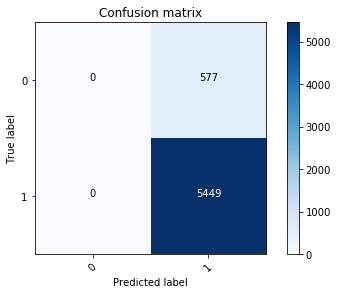

In [14]:
import itertools
plt.figure()
class_names = np.array(['0', '1'])
plot_confusion_matrix(RF_cm, classes=class_names, normalize=False,
                      title='Confusion matrix')

plt.show()

In [15]:
#### Predicition on test data ####
y_pred_RF_prob = RF_model_cat.predict_proba(test_data)
pred_values= pd.DataFrame(y_pred_RF_prob)

submission_simple_RF= pd.DataFrame()
submission_simple_RF['id'] = test_data_id

submission_simple_RF['target'] = pd.DataFrame(pred_values.iloc[:,1])
submission_simple_RF = submission_simple_RF.set_index('id')

submission_simple_RF.columns
submission_simple_RF.head()
## Write to CSV
submission_simple_RF.to_csv("randomForestVersion4.csv")

# Score of 0.26302

In [29]:
oob_error = 1 - RF_model_cat.oob_score_
print('Out of Bag Error: %.3f' % oob_error)

Out of Bag Error: 0.101


In [34]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

features = X_train.columns.values
x, y = (list(x) for x in zip(*sorted(zip(RF_model_cat.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')


In [37]:
trace = go.Scatter(
    y = RF_model_cat.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = RF_model_cat.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')